# FIW Dataset Preprocessing for Kinship Recognition Model

This notebook provides a comprehensive guide to preprocess the FIW (Families In the Wild) dataset for use in a kinship recognition model. The preprocessing steps include:

1. **Importing Necessary Libraries**
2. **Initializing the FaceAnalysis Model**
3. **Analyzing and Verifying the Dataset**
4. **Processing and Aligning Faces**
5. **Saving Metadata to CSV**
6. **Logging and Error Handling**

Let's get started!

In [11]:
# Import necessary libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
import logging
import pandas as pd
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from insightface.utils import face_align


## 2. Initialize the FaceAnalysis Model

We'll initialize the `FaceAnalysis` model using the `buffalo_l` backend. This model is capable of detecting faces, estimating age and gender, and providing facial landmarks.

**Note:** Since your images are already cropped faces, we'll adjust the detection parameters to better suit the dataset.

In [12]:
# Initialize FaceAnalysis
def initialize_face_analysis():
    # Use 'buffalo_l' model which includes detection and alignment
    app = FaceAnalysis(name='buffalo_l')
    # Set ctx_id=0 to use GPU, or ctx_id=-1 to use CPU
    # Since images are already cropped, set det_size smaller
    app.prepare(ctx_id=0, det_size=(128, 128))  # Adjust det_size as needed
    return app

# Initialize the model
app = initialize_face_analysis()
print("FaceAnalysis model initialized.")

/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/samir/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

## 3. Analyze and Verify the Dataset

Before processing, it's essential to understand the dataset's structure and ensure that the images are in the expected format. We'll perform the following analyses:

- **Total Families**
- **Total Individuals**
- **Total Images**
- **Images per Family**
- **Images per Individual**
- **Visualizing Distributions**

This helps in identifying any anomalies or imbalances in the dataset.

Total families: 571
Total individuals: 3591
Total images: 21920

Family-wise statistics:
       Num_Individuals   Num_Images
count       571.000000   571.000000
mean          6.288967    38.388792
std           2.709088    50.833710
min           3.000000     3.000000
25%           5.000000    23.000000
50%           6.000000    32.000000
75%           7.000000    43.000000
max          42.000000  1125.000000

Individual-wise statistics:
        Num_Images
count  3591.000000
mean      6.104149
std       7.892824
min       0.000000
25%       2.000000
50%       5.000000
75%       8.000000
max     242.000000


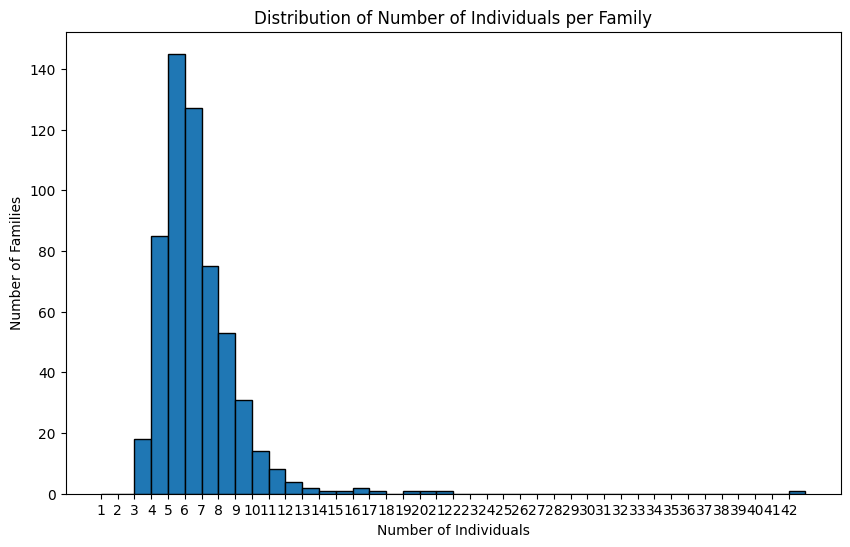

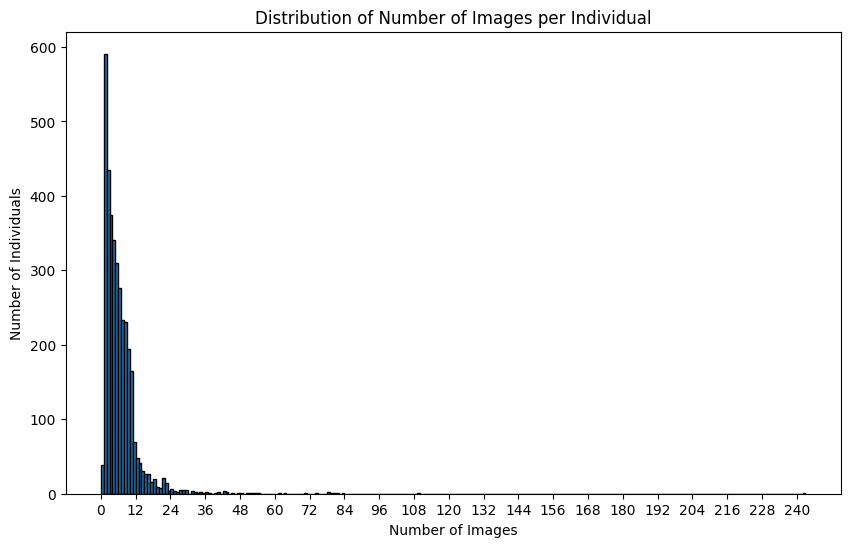

In [13]:
# Define the dataset path
INPUT_ROOT = '../data/raw/fiw/train/train-faces'  # Update this path if necessary

# Function to analyze the dataset
def analyze_dataset(dataset_path):
    family_counts = {}
    individual_counts = {}
    image_counts = {}
    
    families = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    families.sort()
    
    total_families = len(families)
    total_individuals = 0
    total_images = 0
    
    for family in families:
        family_path = os.path.join(dataset_path, family)
        # Include all directories, including 'unrelated_and_nonfaces'
        members = [d for d in os.listdir(family_path) if os.path.isdir(os.path.join(family_path, d))]
        num_members = len(members)
        family_counts[family] = num_members
        total_individuals += num_members
        
        for member in members:
            member_path = os.path.join(family_path, member)
            images = [f for f in os.listdir(member_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            num_images = len(images)
            individual_key = f"{family}_{member}"  # Unique identifier
            individual_counts[individual_key] = num_images
            image_counts[family] = image_counts.get(family, 0) + num_images
            total_images += num_images
            
    # Create DataFrames for analysis
    family_df = pd.DataFrame({
        'Family': list(family_counts.keys()),
        'Num_Individuals': list(family_counts.values()),
        'Num_Images': [image_counts[f] for f in family_counts.keys()]
    })
    
    individual_df = pd.DataFrame({
        'Individual': list(individual_counts.keys()),
        'Num_Images': list(individual_counts.values())
    })
    
    print("Total families:", total_families)
    print("Total individuals:", total_individuals)
    print("Total images:", total_images)
    
    print("\nFamily-wise statistics:")
    print(family_df.describe())
    
    print("\nIndividual-wise statistics:")
    print(individual_df.describe())
    
    # Plotting distributions
    plt.figure(figsize=(10, 6))
    plt.hist(family_df['Num_Individuals'], bins=range(1, family_df['Num_Individuals'].max()+2), edgecolor='black')
    plt.title('Distribution of Number of Individuals per Family')
    plt.xlabel('Number of Individuals')
    plt.ylabel('Number of Families')
    plt.xticks(range(1, family_df['Num_Individuals'].max()+1))
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.hist(individual_df['Num_Images'], bins=range(0, individual_df['Num_Images'].max()+2), edgecolor='black')
    plt.title('Distribution of Number of Images per Individual')
    plt.xlabel('Number of Images')
    plt.ylabel('Number of Individuals')
    plt.xticks(range(0, individual_df['Num_Images'].max()+1, max(1, individual_df['Num_Images'].max()//20)))
    plt.show()
    
    return family_df, individual_df

# Run the analysis
family_df, individual_df = analyze_dataset(INPUT_ROOT)

## 4. Process and Align Faces

We'll iterate through each image in the dataset, detect faces, align them, and save the processed images to an output directory while maintaining the original directory structure. Additionally, we'll log any images where face detection fails.

In [14]:
# Define the output directory
OUTPUT_ROOT = '../data/processed/fiw/train'  # Update this path if necessary
os.makedirs(OUTPUT_ROOT, exist_ok=True)

### 4.1. Define Face Processing Function

This function will handle the processing of each image: detecting faces, aligning them, saving the processed images, and collecting metadata for CSV.

In [15]:
# Define face processing function
def process_image(app, image_path, output_path):
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            logging.warning(f"Failed to load image: {image_path}")
            return None
        
        # Detect faces
        faces = app.get(img)
        if not faces:
            logging.warning(f"No face detected in image: {image_path}")
            return None
        
        # Since images are cropped, take the first detected face
        face = faces[0]
        
        # Align the face
        kps = face.kps.astype(int)
        aligned_face = face_align.norm_crop(img, kps)
        if aligned_face is None:
            logging.warning(f"Failed to align face in image: {image_path}")
            return None
        
        # Save the aligned face image
        cv2.imwrite(output_path, aligned_face)
        
        # Extract metadata
        family = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
        member = os.path.basename(os.path.dirname(image_path))
        image_name = os.path.basename(image_path)
        metadata = {
            'Family': family,
            'Member': member,
            'Original_Image_Name': image_name,
            'Aligned_Image_Path': output_path,
            'Detection_Score': face.det_score,
            'Age': face.age,
            'Gender': face.sex
        }
        
        return metadata
    except Exception as e:
        logging.error(f"Error processing image {image_path}: {e}")
        return None


### 4.2. Process All Images and Collect Metadata

We'll iterate through each family and member, process each image, and collect metadata to save into a CSV file.

In [16]:
# Initialize logging
logging.basicConfig(
    filename='preprocessing.log',
    filemode='a',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

# Initialize a list to store metadata
metadata_list = []

# Function to process all images and collect metadata
def process_all_images(input_root, output_root, app):
    families = [d for d in os.listdir(input_root) if os.path.isdir(os.path.join(input_root, d))]
    families.sort()
    
    for family in tqdm(families, desc="Processing families"):
        family_path = os.path.join(input_root, family)
        output_family_path = os.path.join(output_root, family)
        os.makedirs(output_family_path, exist_ok=True)
        
        # Process all members, including 'unrelated_and_nonfaces'
        members = [d for d in os.listdir(family_path) if os.path.isdir(os.path.join(family_path, d))]
        
        for member in members:
            member_path = os.path.join(family_path, member)
            output_member_path = os.path.join(output_family_path, member)
            os.makedirs(output_member_path, exist_ok=True)
            
            images = [f for f in os.listdir(member_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            
            for image_name in images:
                image_path = os.path.join(member_path, image_name)
                output_image_path = os.path.join(output_member_path, image_name)
                
                # Process and align the face
                metadata = process_image(app, image_path, output_image_path)
                
                if metadata:
                    metadata_list.append(metadata)
                else:
                    logging.warning(f"Failed to process image: {image_path}")
                    
process_all_images(INPUT_ROOT, OUTPUT_ROOT, app)


Processing families:   0%|          | 0/571 [00:00<?, ?it/s]/Users/samir/miniforge3/envs/kinship_recognition/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
Processing families: 100%|██████████| 571/571 [34:51<00:00,  3.66s/it]  


## 5. Save Metadata to CSV

After processing all images, we'll save the collected metadata into a CSV file for easy reference and further analysis.

In [17]:
# Convert metadata list to DataFrame
metadata_df = pd.DataFrame(metadata_list)

# Define CSV path
CSV_PATH = os.path.join(OUTPUT_ROOT, 'fiw_metadata.csv')

# Save to CSV
metadata_df.to_csv(CSV_PATH, index=False)

print(f"Metadata saved to {CSV_PATH}")


Metadata saved to ../data/processed/fiw/train/fiw_metadata.csv


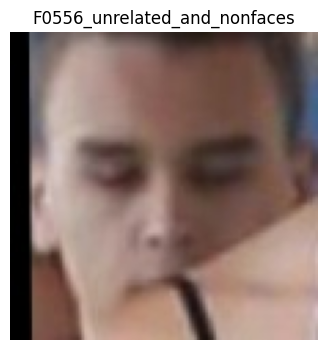

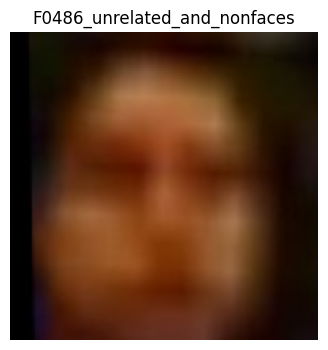

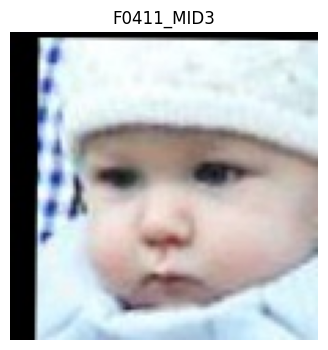

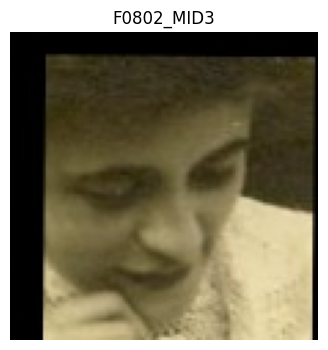

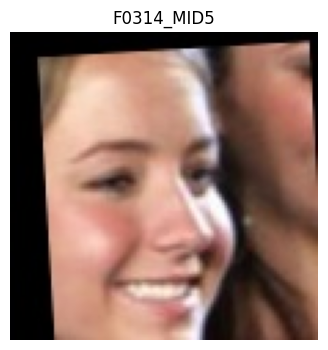

In [22]:
# visualize the aligned faces
def visualize_faces(metadata_df, num_faces=5):
    # Display a few random faces
    for i in range(num_faces):
        i = np.random.randint(len(metadata_df))
        metadata = metadata_df.iloc[i]
        img = cv2.imread(metadata['Aligned_Image_Path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"{metadata['Family']}_{metadata['Member']}")
        plt.axis('off')
        plt.show()
        
visualize_faces(metadata_df)

In [34]:
# Define the path to train-pairs.csv
INPUT_ROOT = '../data/raw/fiw/train/'
PAIR_CSV_PATH = os.path.join(INPUT_ROOT, 'train-pairs.csv')

# Load the CSV into a DataFrame
pairs_df = pd.read_csv(PAIR_CSV_PATH)
print("Columns in pairs_df:", pairs_df.columns.tolist())

# Display the first few rows
print(pairs_df.head())


Columns in pairs_df: ['p1', 'p2', 'ptype', 'fid1', 'fid2', 'tags', 'set', 'nsamples']
           p1          p2 ptype   fid1   fid2  tags  set  nsamples
0  F0001/MID1  F0001/MID3    fs  F0001  F0001     0    0         6
1  F0001/MID1  F0001/MID4    fs  F0001  F0001     0    0        18
2  F0001/MID2  F0001/MID4    ms  F0001  F0001     0    0        15
3  F0001/MID2  F0001/MID3    ms  F0001  F0001     0    0         5
4  F0001/MID3  F0001/MID4    ss  F0001  F0001     0    0         3


In [35]:
import os
import glob

def get_aligned_images(member_identifier, processed_root):
    """
    Retrieve all aligned image paths for a given member.

    Args:
        member_identifier (str): Identifier in the format 'FXXXX/MIDx'.
        processed_root (str): Root directory where processed images are stored.

    Returns:
        list: List of aligned image file paths.
    """
    family, member = member_identifier.split('/')
    member_dir = os.path.join(processed_root, family, member)
    if not os.path.exists(member_dir):
        logging.warning(f"Member directory does not exist: {member_dir}")
        return []
    
    aligned_images = glob.glob(os.path.join(member_dir, '*.jpg')) + \
                     glob.glob(os.path.join(member_dir, '*.png')) + \
                     glob.glob(os.path.join(member_dir, '*.jpeg'))
    return aligned_images


processed_root = '../data/processed/fiw/train'
sample_member = 'F0001/MID1'
aligned_images = get_aligned_images(sample_member, processed_root)
print(aligned_images)


['../data/processed/fiw/train/F0001/MID1/P00002_face0.jpg', '../data/processed/fiw/train/F0001/MID1/P00004_face1.jpg', '../data/processed/fiw/train/F0001/MID1/P00003_face0.jpg', '../data/processed/fiw/train/F0001/MID1/P00008_face4.jpg', '../data/processed/fiw/train/F0001/MID1/P00001_face0.jpg', '../data/processed/fiw/train/F0001/MID1/P00007_face1.jpg']


In [36]:
def gather_all_unrelated_images(processed_root):
    """
    Gather all unrelated and non-faces images from all families.

    Args:
        processed_root (str): Root directory where processed images are stored.

    Returns:
        list: List of unrelated image file paths.
    """
    unrelated_images = []
    families = [d for d in os.listdir(processed_root) if os.path.isdir(os.path.join(processed_root, d))]
    for family in families:
        unrelated_dir = os.path.join(processed_root, family, 'unrelated_and_nonfaces')
        if os.path.exists(unrelated_dir):
            images = glob.glob(os.path.join(unrelated_dir, '*.jpg')) + \
                     glob.glob(os.path.join(unrelated_dir, '*.png')) + \
                     glob.glob(os.path.join(unrelated_dir, '*.jpeg'))
            unrelated_images.extend(images)
        else:
            logging.warning(f"'unrelated_and_nonfaces' directory not found for family: {family}")
    return unrelated_images

# Gather all unrelated images
all_unrelated_images = gather_all_unrelated_images(processed_root)
print(f"Total unrelated images collected: {len(all_unrelated_images)}")


Total unrelated images collected: 4517


In [40]:
import random
from tqdm import tqdm

def generate_triplets(pairs_df, processed_root, unrelated_images):
    """
    Generate triplet samples based on the pairs dataframe, including kinship type labels.
    
    Args:
        pairs_df (pd.DataFrame): DataFrame containing pair information.
        processed_root (str): Root directory where processed images are stored.
        unrelated_images (list): List of unrelated image file paths.
    
    Returns:
        list of tuples: Each tuple contains (anchor, positive, negative, ptype)
    """
    triplets = []
    
    # Check if required columns exist
    required_columns = ['p1', 'p2', 'nsamples', 'ptype']
    for col in required_columns:
        if col not in pairs_df.columns:
            raise KeyError(f"Column '{col}' not found in pairs_df. Available columns: {pairs_df.columns.tolist()}")
    
    for idx, row in tqdm(pairs_df.iterrows(), total=pairs_df.shape[0], desc="Generating triplets"):
        p1 = row['p1']  # e.g., 'F0001/MID1'
        p2 = row['p2']  # e.g., 'F0001/MID3'
        nsamples = row['nsamples']  # e.g., 6
        ptype = row['ptype']  # e.g., 'fs'
        
        # Validate nsamples
        if not isinstance(nsamples, (int, float)) or nsamples < 1:
            logging.warning(f"Invalid nsamples value at row {idx}: {nsamples}. Skipping this pair.")
            continue
        
        # Retrieve aligned images for p1 and p2
        p1_images = get_aligned_images(p1, processed_root)
        p2_images = get_aligned_images(p2, processed_root)
        
        if len(p1_images) == 0:
            logging.warning(f"No images found for p1: {p1}. Skipping this pair.")
            continue
        if len(p2_images) == 0:
            logging.warning(f"No images found for p2: {p2}. Skipping this pair.")
            continue
        
        for _ in range(int(nsamples)):
            anchor = random.choice(p1_images)
            positive = random.choice(p2_images)
            negative = random.choice(unrelated_images)
            triplets.append((anchor, positive, negative, ptype))
    
    return triplets

# Generate triplets with labels
try:
    triplets = generate_triplets(pairs_df, PROCESSED_ROOT, all_unrelated_images)
    print(f"Total triplets generated: {len(triplets)}")
except KeyError as e:
    print(f"KeyError encountered: {e}")

# Define the triplet CSV path
TRIPLET_CSV_PATH = os.path.join(PROCESSED_ROOT, 'triplets_with_labels.csv')

# Create a DataFrame for triplets with labels
triplet_df = pd.DataFrame(triplets, columns=['Anchor', 'Positive', 'Negative', 'ptype'])

# Assign an ID to each triplet
triplet_df['Triplet_ID'] = triplet_df.index + 1

# Reorder columns for clarity
triplet_df = triplet_df[['Triplet_ID', 'Anchor', 'Positive', 'Negative', 'ptype']]

# Save to CSV
triplet_df.to_csv(TRIPLET_CSV_PATH, index=False)

print(f"Triplets with labels saved to {TRIPLET_CSV_PATH}")



Generating triplets: 100%|██████████| 6983/6983 [00:01<00:00, 4538.52it/s]


Total triplets generated: 264540
Triplets with labels saved to ../data/processed/fiw/train/triplets_with_labels.csv


## 6. Logging and Error Handling

All processing steps, warnings, and errors are logged in the `preprocessing.log` file. Review this log to identify and troubleshoot any issues with specific images.

## 7. Conclusion and Next Steps

You've successfully preprocessed the FIW dataset by aligning and saving the images, including those from the `unrelated_and_nonfaces` directory. Additionally, you've collected and saved metadata for each image, which is essential for training your kinship recognition model.

### **Next Steps:**

1. **Verify Data Quality:** Manually inspect a subset of aligned images to ensure alignment is correct.
2. **Prepare Data Splits:** Divide the dataset into training, validation, and testing sets, ensuring that families are not split across different sets to prevent data leakage.
3. **Model Development:** Use the preprocessed dataset and the metadata CSV to train your kinship recognition model.
4. **Further Optimization:** Depending on model performance, consider additional preprocessing steps or more sophisticated alignment techniques.

Feel free to reach out if you encounter any issues or need further assistance with the next steps!